## Sagnac Frequency - Backscatter Correction - Mulit-Regression Model

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

# hardly jumps or splits
config['tbeg'] = UTCDateTime("2024-03-26 12:00")
config['tend'] = UTCDateTime("2024-03-31 00:00")
flim1, flim2 = 302.42, 302.50

# splits
config['tbeg'] = UTCDateTime("2024-03-28 12:00")
config['tend'] = UTCDateTime("2024-03-30 21:00")
flim1, flim2 = 302.40, 302.48

#
# config['tbeg'] = UTCDateTime("2024-03-31 18:00")
# config['tend'] = UTCDateTime("2024-04-03 00:00")
# flim1, flim2 = 302.42, 302.50


## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"


config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

In [4]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

In [5]:
def __makeplot_corr_matrix(ddf, target, m="pearson"):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    _df = ddf.copy()

    if "time" in list(_df.columns):
        _df.drop(columns="time", inplace=True)

    _df = _df.iloc[:, :]

    corr = _df.corr(method=m)

    # mask upper triangle
    corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

    print(corr)

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    cmap = plt.get_cmap("coolwarm", 9)

    # Generate a mask for the upper triangle
    # mask = np.zeros_like(corr, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

    im = plt.pcolor(corr, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    plt.colorbar(im, extend="both")

    labels = list(corr.columns)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(labels))+0.5)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(len(labels))+0.5)
    ax.set_yticklabels(labels)


    fig.suptitle(f'{m} correlation matrix', fontsize=15)

    fig.tight_layout();

    return fig

In [6]:
def __predict_model(ddf, _features, target="fj_fs", reg="theilsen"):

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)

    # prediction
    model_predict = []

    for o, row in df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    modell = {}
    modell['model'] = model
    modell['r2'] = model.score(X, y)

    return model_predict, modell

In [7]:
def __makeplot(df0, modell, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df[target], color="k", label="observed")
    ax.plot(df0.time*tscale, model_predict, color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=4, fontsize=font-2)

    ax.set_ylabel(f"$\Delta$f (Hz)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.2f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

    ax.set_title(target)

    plt.show();
    return fig

### Read Dataframe

In [8]:
df = read_pickle(config['path_to_out_data']+"multi_regression_df.pkl")

In [9]:
# df.plot(x="time", y=list(df.columns), subplots=True, figsize=(15, 10))

### Define features

In [10]:
# specify target column
target = 'fj_bs'

# create list for features
# features = list(df.columns)
features = ['time', target, 'bwx', 'bwy', 'bdo', 'bdf', 'ps9', 'ps5', 'ps3', 'ps1']

df0 = df[features]


       fj_bs       bwx       bwy       bdo       bdf       ps9       ps5  \
fj_bs    NaN  0.149201  0.181318 -0.092324 -0.129811  0.398023  0.333024   
bwx      NaN       NaN -0.235648  0.559297 -0.040879  0.390940  0.023242   
bwy      NaN       NaN       NaN -0.925598 -0.403385  0.274398  0.448006   
bdo      NaN       NaN       NaN       NaN  0.348527 -0.120684 -0.404978   
bdf      NaN       NaN       NaN       NaN       NaN -0.065121 -0.102354   
ps9      NaN       NaN       NaN       NaN       NaN       NaN  0.769875   
ps5      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ps3      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
ps1      NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            ps3       ps1  
fj_bs  0.058867 -0.030632  
bwx    0.549923 -0.764341  
bwy    0.223405  0.399537  
bdo   -0.024159 -0.619577  
bdf   -0.115137 -0.058166  
ps9    0.602638 -0.201254  
ps5    0.456120  0.108120  
ps3         NaN

/tmp/ipykernel_3127652/3102599813.py:37: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im, extend="both")


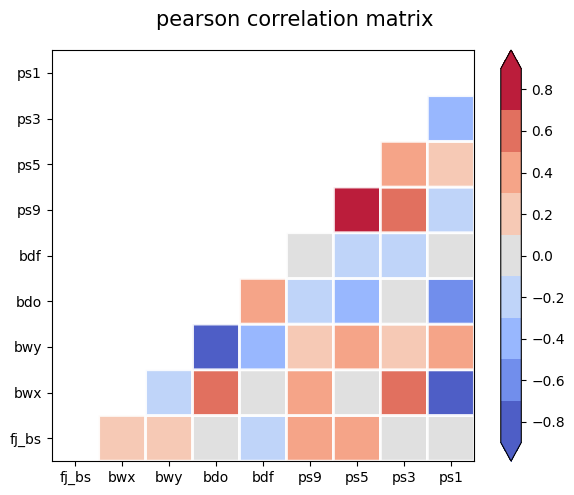

In [11]:
fig = __makeplot_corr_matrix(df0, target, m="pearson")

fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_ccmatrix_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')

## Modelling

In [12]:
model_predict, modell = __predict_model(df, features, target="fj_bs", reg="theilsen")

R2: 0.2392753850934385
X0: 0.00195862070185509
Coef:  [ 0.50423643  0.86069294  0.07669713 -0.00089686  0.21030577  0.13670023
 -0.02879287  0.10015923]


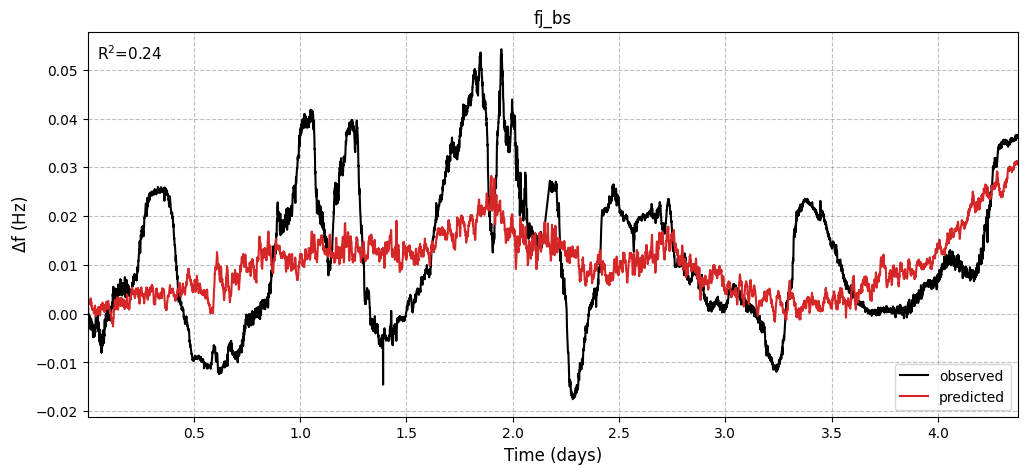

In [13]:
fig = __makeplot(df, modell,'fj_bs');

fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_model_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')

## Beam Wander

In [14]:
def __makeplot(df0, modell, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df[target], color="k", label="observed")
    ax.plot(df0.time*tscale, model_predict, color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=4, fontsize=font-2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.2f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

    ax.set_title(target)

    plt.show();
    return fig

In [20]:

features = ['time', 'bwx', 'bwy', 'bdo', 'ps1', 'ps5', 'ps9', 'mae', 'man']

df1 = df[features]

target = "bwx"

     bwx       bwy       bdo       ps1       ps5       ps9       mae       man
bwx  NaN -0.080118  0.276227 -0.545009 -0.105413  0.113443  0.089471 -0.808731
bwy  NaN       NaN -0.771855  0.249042  0.380466  0.286988 -0.623822  0.252448
bdo  NaN       NaN       NaN -0.387013 -0.340058 -0.194795  0.631691 -0.460946
ps1  NaN       NaN       NaN       NaN  0.163191 -0.019141 -0.197743  0.621305
ps5  NaN       NaN       NaN       NaN       NaN  0.511765 -0.302682  0.179384
ps9  NaN       NaN       NaN       NaN       NaN       NaN -0.180802 -0.024823
mae  NaN       NaN       NaN       NaN       NaN       NaN       NaN -0.257148
man  NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN


/tmp/ipykernel_3127652/3102599813.py:37: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im, extend="both")


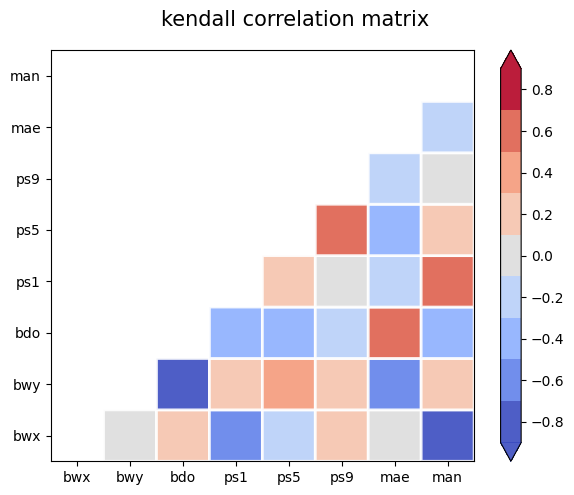

In [21]:
fig = __makeplot_corr_matrix(df1, target, m="kendall")

fig.savefig(config['path_to_figs']+f"SF_BS_RU_beamwander_{target}_ccmatrix.png", format="png", dpi=150, bbox_inches='tight')


In [22]:
model_predict, modell = __predict_model(df1, features, target=target, reg="ransac")

R2: 0.7914860240388331


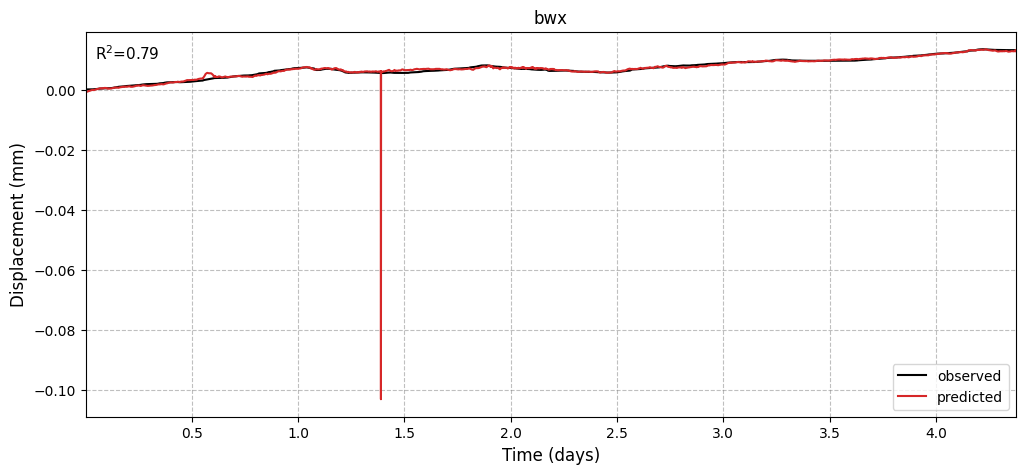

In [23]:
fig = __makeplot(df1, modell, target)

fig.savefig(config['path_to_figs']+f"SF_BS_RU_beamwander_{target}_predicted.png", format="png", dpi=150, bbox_inches='tight')


In [19]:

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import linear_model
# from mpl_toolkits.mplot3d import Axes3D

# ######################################## Data preparation #########################################

# X = df[['mae', 'man']].values.reshape(-1, 2)
# Y = df['fj_bs']

# ######################## Prepare model data point for visualization ###############################

# x = X[:, 0]
# y = X[:, 1]
# z = Y

# x_pred = np.linspace(6, 24, 30)      # range of porosity values
# y_pred = np.linspace(0.93, 2.9, 30)  # range of VR values
# xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
# model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# ################################################ Train #############################################

# ols = linear_model.LinearRegression()
# model = ols.fit(X, Y)
# predicted = model.predict(model_viz)

# ############################################## Evaluate ############################################

# r2 = model.score(X, Y)

# ############################################## Plot ################################################

# plt.style.use('default')

# fig = plt.figure(figsize=(12, 4))

# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
# ax3 = fig.add_subplot(133, projection='3d')

# axes = [ax1, ax2, ax3]

# for ax in axes:
#     ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
#     ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
#     ax.set_xlabel('Porosity (%)', fontsize=12)
#     ax.set_ylabel('VR', fontsize=12)
#     ax.set_zlabel('Gas Prod. (Mcf/day)', fontsize=12)
#     ax.locator_params(nbins=4, axis='x')
#     ax.locator_params(nbins=5, axis='x')

# ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax1.transAxes, color='grey', alpha=0.5)
# ax2.text2D(0.3, 0.42, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax2.transAxes, color='grey', alpha=0.5)
# ax3.text2D(0.85, 0.85, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#            transform=ax3.transAxes, color='grey', alpha=0.5)

# ax1.view_init(elev=27, azim=112)
# ax2.view_init(elev=16, azim=-51)
# ax3.view_init(elev=60, azim=165)

# fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

# fig.tight_layout();

